In [173]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import glob

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from time import strftime
%matplotlib inline

In [2]:
filedirec = r"D:\Files_Reutlingen_Jenny\main_191021extra"
inputdirectory = r"D:\Files_Reutlingen_Jenny\main_191021extra\191021_extra"
os.chdir(inputdirectory)

In [3]:
filelist = glob.glob('*.h5')
filelist

['aCSF_adult_15min_spont.h5',
 'hCSF_adult_20min_spont0002.h5',
 'hCSF_child_20min_spont.h5']

In [4]:
labeldic = np.load('labeldictionary_MCS_256MEA.npy', allow_pickle='TRUE').item()

In [5]:
filename=filelist[0]


In [6]:
filebase = filename.split('.')[0]

In [6]:
recording_MEA=se.MCSH5RecordingExtractor(os.path.join(inputdirectory, filename))
recording_f = st.preprocessing.bandpass_filter(recording_MEA, freq_min=150, freq_max=5000, filter_type='butter', order=2)
recording_cmr = st.preprocessing.common_reference(recording_f, reference='median')


In [7]:
recording_cmrprobe=recording_MEA.load_probe_file(probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb")

In [6]:
timestr = strftime("%d%m%Y")
outputdirectory = os.path.join(filedirec, '_output_Spikesorting_'+ timestr).replace('\\','/')

probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb"
outputdirectory_SC='D:/Files_Reutlingen_Jenny/main_191021extra/191021_extra_Spikesorting/output_Spykingcirucs'


In [7]:
outputdirectory

'D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_20042021'

In [8]:
outpath=os.path.join(outputdirectory+'_'+filename.split('.')[0]+'_spikesorting').replace("\\","/")
try:
    os.mkdir(outpath)
except OSError:
    print ("Creation of the directory %s failed" % outpath)
else:
    print ("Successfully created the directory %s " % outpath)

Successfully created the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_20042021_aCSF_adult_15min_spont_spikesorting 


In [9]:
outpath_SC=os.path.join(outpath, 'output_spykingcircus').replace("\\","/")
try:
    os.mkdir(outpath_SC)
except OSError:
    print ("Creation of the directory %s failed" % outpath)
else:
    print ("Successfully created the directory %s " % outpath)

Successfully created the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_20042021_aCSF_adult_15min_spont_spikesorting 


In [7]:
outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting'

In [8]:
os.chdir(outpath)

In [13]:
# cutting out 2 minutes

fs = recording_cmrprobe.get_sampling_frequency()
fs = np.round(fs)
#recording_sub = se.SubRecordingExtractor(recording_cmrprobe, start_frame=200*fs, end_frame=320*fs)

NameError: name 'recording_cmrprobe' is not defined

In [22]:
# get the recording length, divide it into 120 second frames
recording_length = recording_cmrprobe.get_num_frames()
recording_seconds = recording_length/fs




In [9]:
def divide_recording_to_sub(recording, sublength_seconds):
    
    
    subrecording_dic = {}
    recording_length = recording.get_num_frames()
    recording_seconds = recording_length/fs
    end_frame = int(recording_seconds)
    
    for snippet in range(0, end_frame, sublength_seconds):
        sub_start = snippet
        sub_end = snippet + sublength_seconds
        if sub_end > end_frame:
            sub_end = end_frame
        sub_str = 'sec_'+str(sub_start)+'-'+str(sub_end)
    
        subrecording_dic[sub_str] = se.SubRecordingExtractor(
            recording_cmrprobe, start_frame = sub_start*fs,
            end_frame = sub_end*fs)
    
    return subrecording_dic
    
    

In [48]:
subrecording_dic

{'sec_0-200': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x28156a46040>,
 'sec_200-400': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x28156022370>,
 'sec_400-600': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x28156a5bb50>,
 'sec_600-800': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x281567c4e50>,
 'sec_800-900': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x281567c4b50>}

In [51]:
subrecords = divide_recording_to_sub(recording_cmrprobe, 300)

In [52]:
subrecords

{'sec_0-300': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x281560b60d0>,
 'sec_300-600': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x2814e8d1be0>,
 'sec_600-900': <spikeextractors.subrecordingextractor.SubRecordingExtractor at 0x281560b6d60>}

In [10]:
# make a cache for every part in the dictionary

def create_cache_for_subrecordings(subrecording_dic, filebase, outpath):

    for key in subrecording_dic:
        sub_cache = se.CacheRecordingExtractor(
            subrecording_dic[key])
        filepath = os.path.join(
            outpath, filebase+str(key)+'_filtered_data.dat'
            ).replace('\\','/')
        sub_cache.move_to(filepath) 
        sub_cache.dump_to_dict()
        filepathpickle = os.path.join(
            outpath, filebase+str(key)+'_recording.pkl'
            ).replace('\\','/')
        sub_cache.dump_to_pickle(filepathpickle)
        
    return 'Finished dumping the subrecords. To load, use the load_dumped_recordings function'
    

In [74]:
create_cache_for_subrecordings(subrecording_dic=subrecords, filebase=filebase, outpath=outpath)

'Finished dumping the subrecords. To load, use the load_dumped_recordings function'

In [11]:
def load_dumped_subrecordings(directory, filebase):

    subrecording_dic = {}
    filelist = glob.glob('*.pkl')
    for file in filelist:
        key = file.split(filebase)[1].split('.')[0].split('_recording')[0]
        subrecording_dic[key]=se.load_extractor_from_pickle(file)
        
    return subrecording_dic
        
    

In [12]:
loaded = load_dumped_subrecordings(outpath, filebase)

In [13]:
loaded

{'sec_0-300': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x1df284dc430>,
 'sec_300-600': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x1df284dc910>,
 'sec_600-900': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x1df284c8b50>}

In [24]:

print(f'Cached channels: {recording_cache.get_channel_ids()}')
print(f'Cached channels ids: {recording_cache.get_channel_ids()}')
print(f'Channel groups after caching: {recording_cache.get_channel_groups()}')

Cached channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [20]:
# to load:
#recording_loaded = se.load_extractor_from_pickle('recording.pkl')
#recording_cache=recording_loaded

In [14]:
# loop to run spikesorter over different subrecordings
def run_spykingcircus_on_sub(subrecording_dic, directory):
    

    sorted_dic={}
    for key in loaded:
        outpath_SC=os.path.join(outpath, 'sorted_'+str(key)).replace('\\', '/')
        '''
        try:
            os.mkdir(outpath_SC)
        except OSError:
            print ("Creation of the directory %s failed" % outpath)
        else:
            print ("Successfully created the directory %s " % outpath)
        '''
        sorted_dic[key]=ss.run_spykingcircus(
            loaded[key], output_folder=outpath_SC)

    return sorted_dic
    

In [104]:
sorted_dic = run_spykingcircus_on_sub(loaded, outpath)

Creation of the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting failed
RUNNING SHELL SCRIPT: D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting\sorted_sec_0-300\run_spykingcircus.bat
Creation of the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting failed
RUNNING SHELL SCRIPT: D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting\sorted_sec_300-600\run_spykingcircus.bat
Creation of the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting failed
RUNNING SHELL SCRIPT: D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting\sorted_sec_600-900\run_spykingcircus.bat


In [105]:
sorted_dic

{'sec_0-300': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x2815658a040>,
 'sec_300-600': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x281563a3370>,
 'sec_600-900': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x28155ffcfd0>}

In [15]:
def load_dumped_sorted_dic(outpath):

    sorted_dic = {}
    filelist = glob.glob('*sorted*')
    for file in filelist:
        key = file.split('sorted_')[1]
        sorted_dic[key]=se.SpykingCircusSortingExtractor(file)
        
    return sorted_dic

In [16]:
sorted_dic = load_dumped_sorted_dic(outpath)

In [17]:
sorted_dic


{'sec_0-300': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x1df284e31c0>,
 'sec_300-600': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x1df284e3070>,
 'sec_600-900': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x1df2ff7d5b0>}

In [18]:
waveforms = st.postprocessing.get_unit_waveforms(
    loaded['sec_0-300'], sorted_dic['sec_0-300'], memmap = True
    )

In [20]:
u = 'sec_0-300'

In [86]:
layerdic = {'layer1':[], 
            'layer2-3':['L1', 'M1', 'M2', 'M3', 'M15', 'M16', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7',
                        'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O1', 'O2', 'O3', 'O4', 
                        'O5', 'O6', 'O7', 'O8', 'O9', 'O10', 'O11', 'O12', 'O13', 'O14', 'O15', 'O16', 'P1', 
                        'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 
                        'P15', 'P16', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 
                        'R13', 'R14', 'R15'],
           'layer4':['K1', 'K2', 'K14', 'K15', 'K16', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 
                     'L13', 'L14', 'L15', 'L16', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14'],
           'layer5-6':['K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'I1', 'I2', 'I3', 'I4', 
                       'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'H1', 'H2', 'H3', 
                       'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 
                      'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16',
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',
                       'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16',
                       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11'],
           'whitematter':['D12', 'D13', 'D14', 'D15', 'D16', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 
                          'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                          'A10', 'A11', 'A12', 'A13', 'A14', 'A15' ]}

In [87]:
# loop to invert
layerdic_invert = {}

for key in layerdic:
    for i in layerdic[key]:
        layerdic_invert[i]=key

In [148]:
labeldic_invert = {}

for key in labeldic:
    keystring = str(labeldic[key])
    labeldic_invert[keystring] = key

In [150]:
labeldic_invert

{'R12': 0,
 'L10': 1,
 'O10': 2,
 'P11': 3,
 'L9': 4,
 'N9': 5,
 'M8': 6,
 'R8': 7,
 'O6': 8,
 'N7': 9,
 'R4': 10,
 'P5': 11,
 'R2': 12,
 'M5': 13,
 'K6': 14,
 'I8': 15,
 'L2': 16,
 'M1': 17,
 'I4': 18,
 'K3': 19,
 'H1': 20,
 'I6': 21,
 'G4': 22,
 'H5': 23,
 'E2': 24,
 'F3': 25,
 'N13': 26,
 'O14': 27,
 'R13': 28,
 'L11': 29,
 'O11': 30,
 'P12': 31,
 'M9': 32,
 'N10': 33,
 'L8': 34,
 'R9': 35,
 'O7': 36,
 'N8': 37,
 'R5': 38,
 'P6': 39,
 'K7': 40,
 'L7': 41,
 'N4': 42,
 'O3': 43,
 'N1': 44,
 'L6': 45,
 'L3': 46,
 'M2': 47,
 'I5': 48,
 'K4': 49,
 'H6': 50,
 'I1': 51,
 'G3': 52,
 'H4': 53,
 'E1': 54,
 'F2': 55,
 'K13': 56,
 'L16': 57,
 'I12': 58,
 'K15': 59,
 'I16': 60,
 'I14': 61,
 'K10': 62,
 'O16': 63,
 'R14': 64,
 'R15': 65,
 'O12': 66,
 'P13': 67,
 'M10': 68,
 'N11': 69,
 'P9': 70,
 'R10': 71,
 'O8': 72,
 'K8': 73,
 'R6': 74,
 'P7': 75,
 'N5': 76,
 'M6': 77,
 'P3': 78,
 'O4': 79,
 'O1': 80,
 'P1': 81,
 'M3': 82,
 'N2': 83,
 'K5': 84,
 'L4': 85,
 'I2': 86,
 'K1': 87,
 'H3': 88,
 'H7'

In [36]:
#load
#sorting_SC = se.SpykingCircusSortingExtractor(outpath_SC)


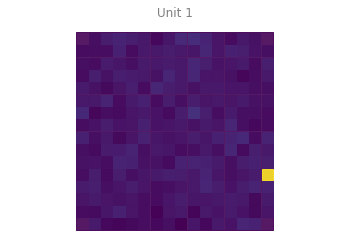

In [22]:
sw.plot_unit_template_maps(loaded['sec_0-300'],  sorted_dic['sec_0-300'], max_spikes_per_unit=100, unit_ids=[1])

{}


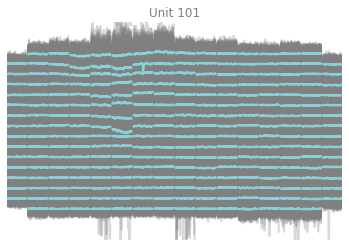

In [23]:
w_wf = sw.plot_unit_waveforms(loaded['sec_0-300'],  sorted_dic['sec_0-300'], unit_ids=[101], color='#89D1D9')

<IPython.core.display.Javascript object>


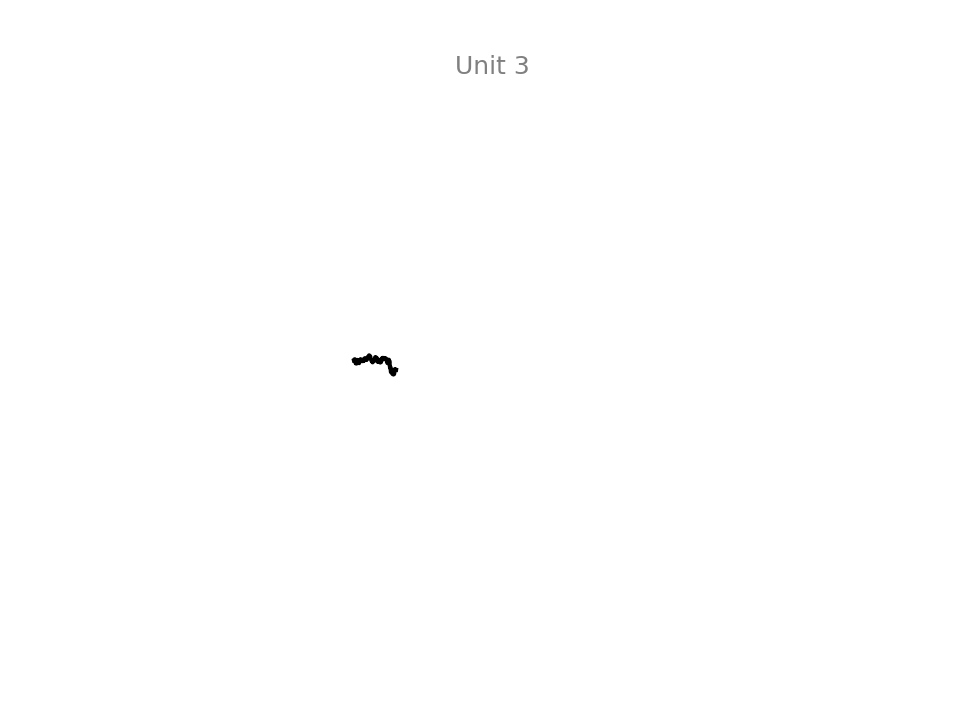

{}


In [132]:
sw.plot_unit_templates(loaded['sec_0-300'],  sorted_dic['sec_0-300'], unit_ids=[3], max_channels=1, )

In [283]:
amplitudes = st.postprocessing.get_unit_amplitudes(loaded['sec_0-300'], sorted_dic['sec_0-300'])

In [293]:
np.mean(amplitudes[2])

5.267176434782609e-05

In [32]:
def units_to_pandas_DataFrame(sorted_dic, recording_cache, dictkey, layerdic_invert):
    
    # creates pandas DataFrame only including the unit ids. the order will be confused because of the unit numbering ('1' instead of '001')
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    unitframe = pd.DataFrame(
        sorted_dic[dictkey].get_unit_ids(), 
        columns=['unit_ids']
        )
    
    
    
    # calculate as many paramters as possible outside of the loop
    recordings_seconds = recording_cache[dictkey].get_num_frames()/recording_cache[dictkey].get_sampling_frequency()
    
    features = st.postprocessing.compute_unit_template_features(
        recording_cache[dictkey], 
        sorted_dic[dictkey], 
        as_dataframe=True
        )
    
    quality_metrics = st.validation.compute_quality_metrics(
        sorted_dic[dictkey], 
        recording_cache[dictkey], 
        metric_names=['firing_rate', 'isi_violation', 'snr', 
                      'amplitude_cutoff', 'presence_ratio'],
        as_dataframe=True
        )
    
    
    for i in unit_ids:  
        
        # add channel with maximum amplitude
        unitframe.loc[(unitframe['unit_ids']==i), 'max_channel']=st.postprocessing.get_unit_max_channels(
            recording_cache[dictkey], sorted_dic[dictkey], unit_ids=[i]
            )
    
        # get the channel label as on MCS MEA 256 chips
        max_channel = int(unitframe.loc[(unitframe['unit_ids']==i)]['max_channel'])
        unitframe.loc[(unitframe['unit_ids']==i), 'channellabel']= labeldic[max_channel]
        
        # get the number of spiks per unit
        unitframe.loc[(unitframe['unit_ids']==i), 'n_spikes']=len(sorted_dic['sec_0-300'].get_unit_spike_train(unit_id=i))
        
        # add firing rate
        unitframe.loc[(unitframe['unit_ids']==i), 'firing_rate']= unitframe.loc[(unitframe['unit_ids']==i)]['n_spikes']/recordings_seconds
        
        # add layer
        labelkey = unitframe.loc[(unitframe['unit_ids']==i), 'channellabel'].values[0]
        unitframe.loc[(unitframe['unit_ids']==i), 'layer']= layerdic_invert[labelkey]
        
        # add features
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_to_valley']=features.loc[i]['peak_to_valley']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_halfwidth']=features.loc[i]['halfwidth']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_trough_ratio']=features.loc[i]['peak_trough_ratio']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_repolarization_slope']=features.loc[i]['repolarization_slope']
        unitframe.loc[(unitframe['unit_ids']==i), 'ft_recovery_slope']=features.loc[i]['recovery_slope']

        # add quality metrics
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_firing_rate']=quality_metrics.loc[i]['firing_rate']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_isi_violation']=quality_metrics.loc[i]['isi_violation']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_amplitude_cutoff']=quality_metrics.loc[i]['amplitude_cutoff']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_presence_ratio']=quality_metrics.loc[i]['presence_ratio']
        unitframe.loc[(unitframe['unit_ids']==i), 'qm_snr']=quality_metrics.loc[i]['snr']
        
    return unitframe

In [33]:
unitframe = units_to_pandas_DataFrame(
    sorted_dic = sorted_dic,
    recording_cache = loaded,
    dictkey='sec_0-300')

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [38]:
unitframe

,unit_ids,max_channel,channellabel,n_spikes,ft_peak_to_valley,ft_halfwidth,ft_peak_trough_ratio,ft_repolarization_slope,ft_recovery_slope,qm_firing_rate,qm_isi_violation,qm_amplitude_cutoff,qm_presence_ratio,qm_snr
0,0,0.0,R12,471.0,0.00028,0.00016,-0.217778,0.096874,-0.001101,1.570000,1.370594,0.014265,1.00,3.861756
1,1,0.0,R12,643.0,0.00072,0.00020,-0.406593,0.031730,-0.004369,2.143333,2.696499,0.029983,1.00,3.123731
2,10,30.0,O11,23.0,0.00104,0.00024,-0.378968,0.198163,-0.015376,0.076667,0.000000,0.011251,0.17,13.500068
3,100,134.0,F8,197.0,0.00116,0.00576,0.801047,NaN,-0.002177,0.656667,5.223085,0.500000,0.87,4.189232
4,101,91.0,G2,1136.0,0.00116,0.00020,-0.130909,0.019108,-0.003019,3.786667,5.733182,0.124681,1.00,4.085365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,95,61.0,I14,673.0,0.00088,0.00036,-0.237921,0.144965,-0.014230,2.243333,0.447537,0.054127,0.96,22.870489
743,96,71.0,R10,357.0,0.00076,0.00024,-0.178694,0.054005,-0.004573,1.190000,1.590461,0.000863,0.98,3.707802
744,97,71.0,R10,1174.0,0.00028,0.00024,-0.232653,0.065513,-0.006351,3.913333,0.220605,0.000863,1.00,3.121689
745,98,81.0,P1,470.0,0.00056,0.00016,-0.184000,0.053292,-0.002263,1.566667,0.917622,0.000863,1.00,3.980520


In [36]:
unit_ids = sorted_dic['sec_0-300'].get_unit_ids()




In [120]:
len(unitframe['channellabel'].unique())

248

# Waveforms and Template Plots

In [90]:
# calculate waveforms 
wf = st.postprocessing.get_unit_waveforms(loaded[u], sorted_dic[u], ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

In [91]:
print(sorted_dic[u].get_shared_unit_spike_feature_names())
print(wf[0].shape)

['amplitudes', 'amplitudes_idxs', 'waveforms', 'waveforms_idxs']
(300, 252, 148)


In [95]:
#fig, ax = plt.subplots()
#ax.plot(wf[0][:, 0, :].T, color='k', lw=0.3)

In [96]:
templates = st.postprocessing.get_unit_templates(loaded[u], sorted_dic[u], max_spikes_per_unit=200, 
                                                 save_as_property=True, verbose=True)

In [313]:
unitframe.loc[2]

unit_ids                          10
max_channel                       30
n_spikes                          23
firing_rate                0.0766667
firing_rate_2              0.0766667
channellabel                     O11
ft_peak_to_valley            0.00104
ft_halfwidth                 0.00024
ft_peak_trough_ratio       -0.378968
ft_repolarization_slope     0.198163
ft_recovery_slope          -0.015376
qm_firing_rate             0.0766667
qm_isi_violation                   0
qm_snr                       13.5001
qm_amplitude_cutoff        0.0112515
qm_presence_ratio               0.17
Name: 2, dtype: object

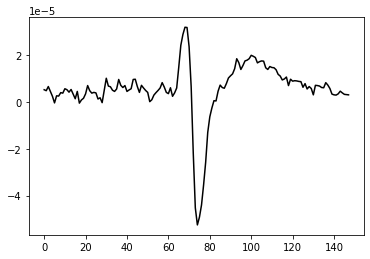

In [314]:
fig, ax = plt.subplots()
ax.plot(templates[2][30].T, color='k')


In [308]:
labeldic[40]

'K7'

idee: templates pro channel darstellen -> also den dataframe nach channel sortieren, dich mit key: channel, value: units

In [345]:
unitlist_by_index = list(unitframe.loc[(unitframe['max_channel'])==0].index)

In [346]:
unitlist_by_channel = list(unitframe.loc[(unitframe['max_channel'])==1]['unit_ids'])

In [347]:
unitlist_by_channel

[80, 81, 82]

In [320]:
j = 0 #entsprich dem maxchannel
#j=labeldic_invert['F8'] 
unitlist_by_index=unitframe.loc[(unitframe['max_channel']==j)].index
unitlist_by_channel = list(unitframe.loc[(unitframe['max_channel'])==j]['unit_ids'])
print(unitlist_by_index)
unitframe.loc[unitlist_by_index[0]]['channellabel']

Int64Index([0, 1], dtype='int64')


'R12'

In [321]:
labeldic_invert[unitframe.loc[unitlist_by_index[0]]['channellabel']]

0

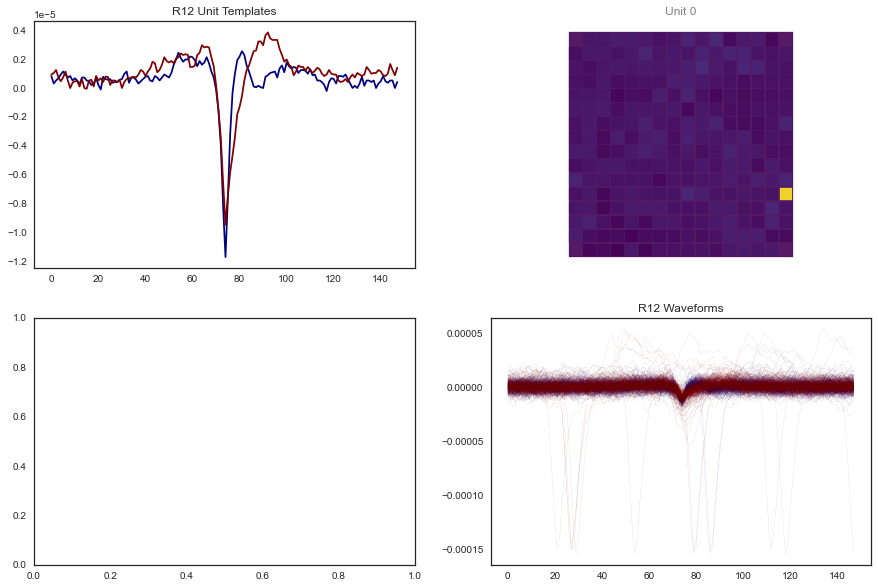

In [322]:
#colourlist = ['#D7D7D9', '#162473', '#449CA6', '#038C73', '#BF4417', '#7EBF88', '#D0F2D3', '#F2CB57']
n = len(unitlist_by_index)
colors = iter(cm.jet(np.linspace(0, 1, len(unitlist_by_index))))

plt.style.use("seaborn-white")

#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
      
sw.plot_unit_template_maps(loaded['sec_0-300'],  sorted_dic['sec_0-300'], max_spikes_per_unit=100, unit_ids=[(unitlist_by_channel[0])], ax=ax2)



#ax3.plot(loaded['sec_0-300'].get_traces()[j])

#sw.plot_timeseries(loaded['sec_0-300'], trange=[5, 8], ax=ax3,)

#sw.plot_activity_map(loaded['sec_0-300'], ax=ax3)

for i in unitlist_by_index:
    colourcode = color=next(colors)
    ax1.plot(templates[i][j].T, color=colourcode)
    ax1.set_title(str(unitframe.loc[i]['channellabel']) + ' Unit Templates')

    ax4.plot(wf[i][:, j, :].T, color=colourcode, lw=0.05)
    ax4.set_title(str(unitframe.loc[i]['channellabel']) + ' Waveforms')
    
    
sw.plot_rasters(sorted_dic[u], color='k', unit_ids=unitlist_by_channel, ax = ax5)

#sw.plot_pca_features(sorting=sorted_dic[u], recording = loaded[u], unit_ids=unitlist_by_channel, ax=ax6)



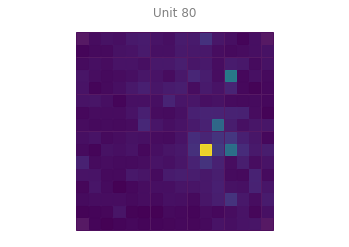

In [336]:
sw.plot_unit_template_maps(loaded['sec_0-300'],  sorted_dic['sec_0-300'], max_spikes_per_unit=100, unit_ids=[80], figure=)

In [ ]:
Continue 22/04:
    - fill in the dataframe with the other parameters
    - dump/pickle the data frame
    - make a plot for every unit

In [ ]:
waveforms = st.postprocessing.get_unit_waveforms(loaded['sec_0-300'], sorted_dic['sec_0-300'], ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

In [125]:
u = 'sec_0-300'

R12
Int64Index([0, 1], dtype='int64')
O11
Int64Index([2, 13, 430, 725, 736], dtype='int64')
F8
Int64Index([  3,   8,  41,  72,  74,  75,  76,  80,  96,  97,  98,  99, 100,
            107, 171, 207, 223, 340, 512, 531, 532, 549, 603, 682],
           dtype='int64')
G2
Int64Index([4, 5, 6, 7, 746], dtype='int64')
P10
Int64Index([9, 10, 11, 12], dtype='int64')


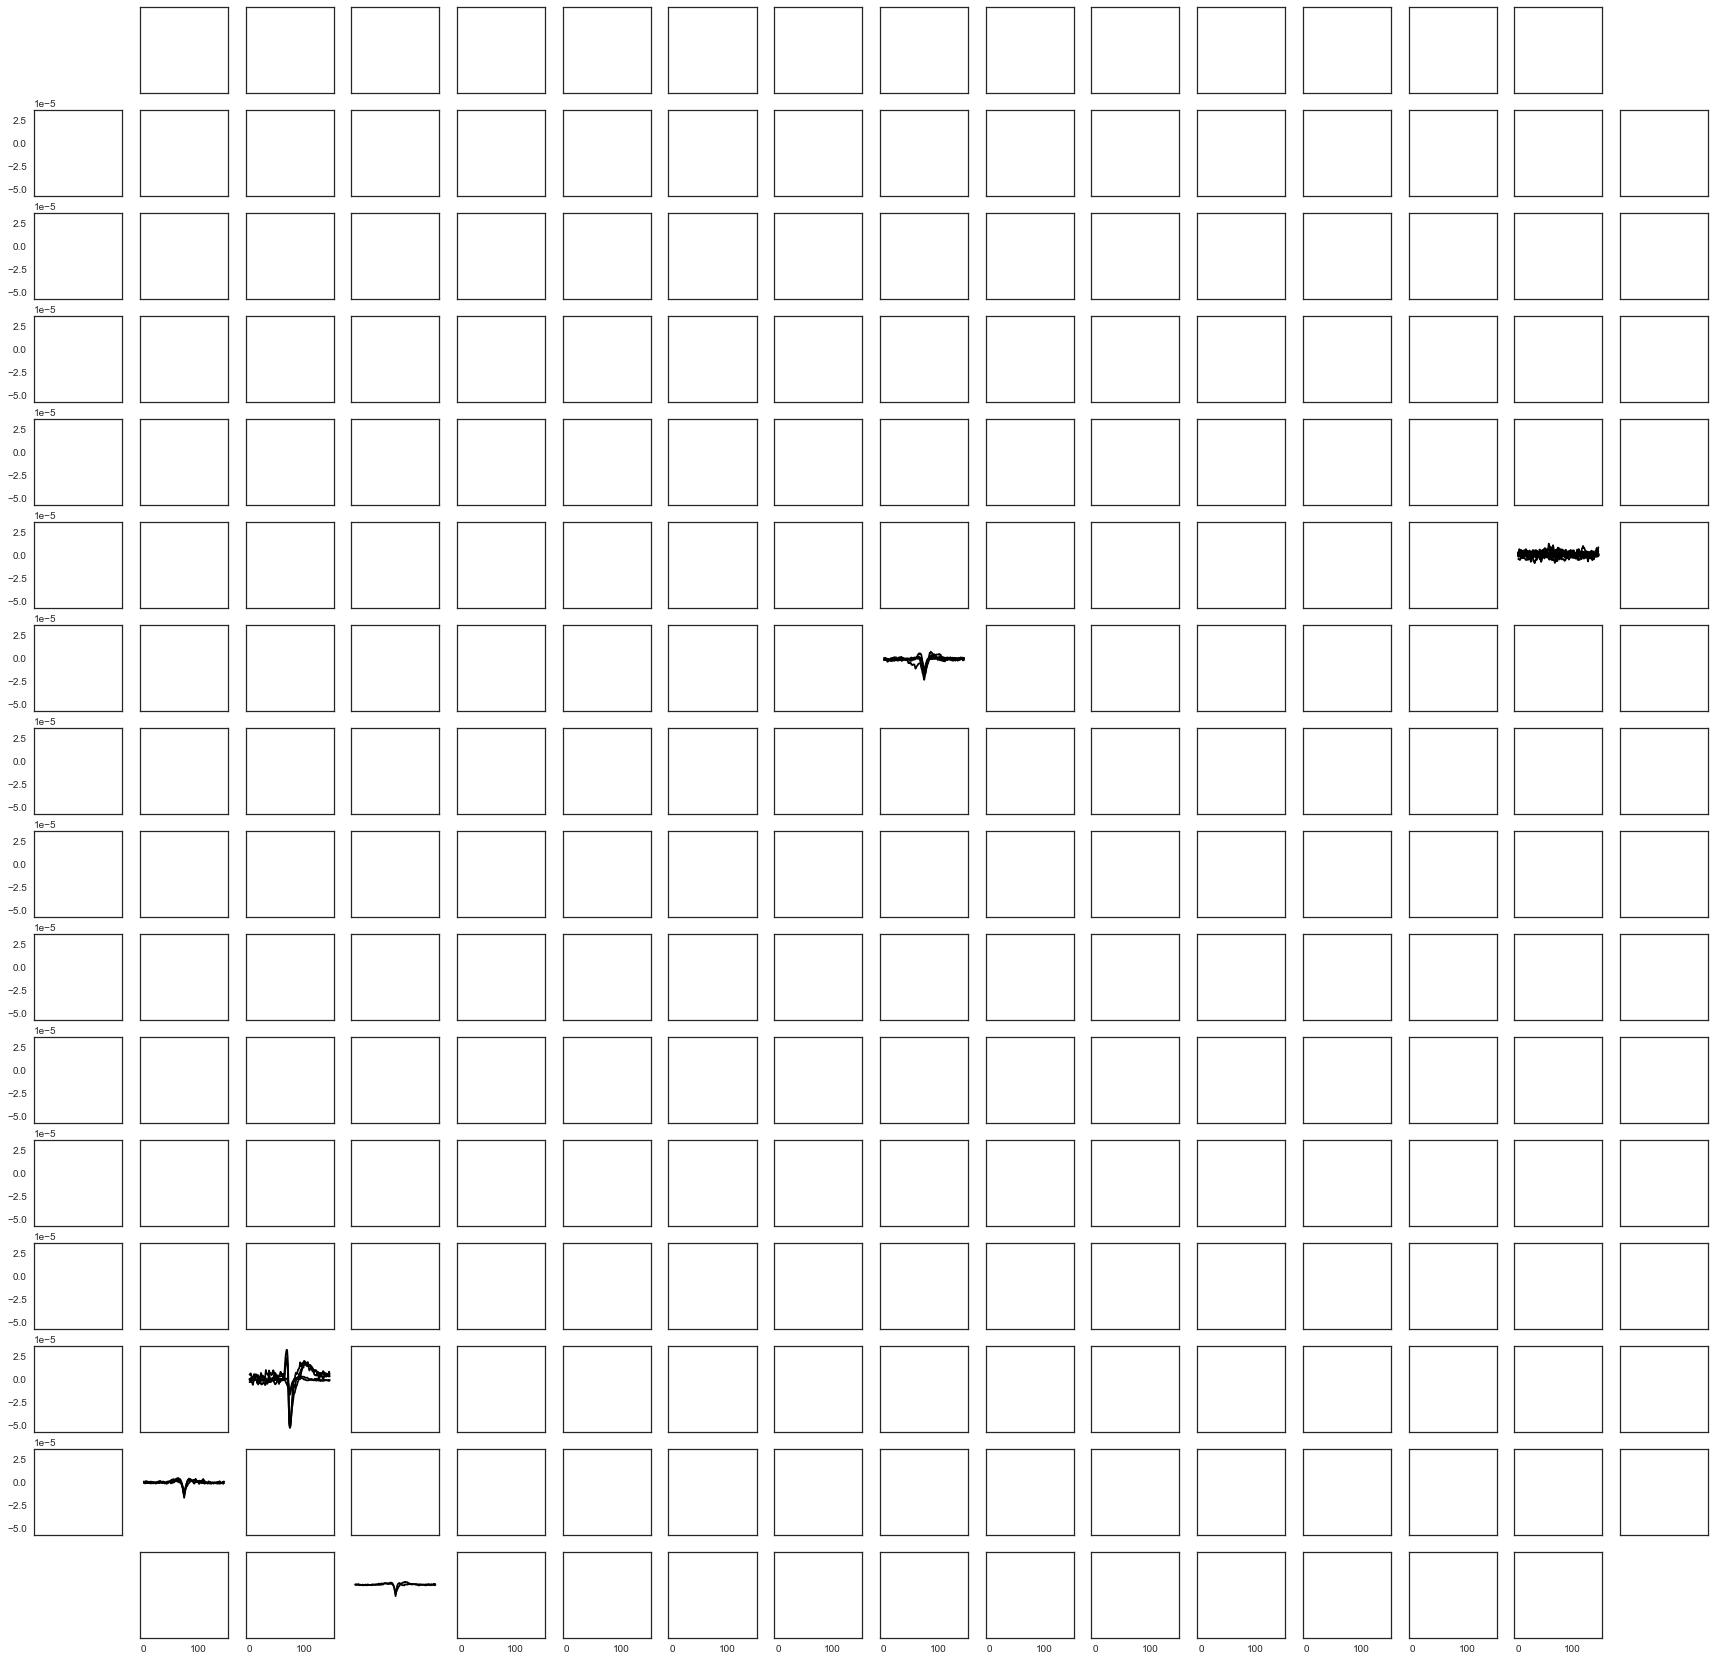

In [309]:
# plots stimmen noch nicht mit den eigentlichen channels überein


fig, ax = plt.subplots(nrows=16, ncols=16, sharex=True, 
                       sharey=True,figsize=(30, 30))

#colors = iter(cm.jet(np.linspace(0, 1, len(unitlist_by_index))))
unique_labels = unitframe['channellabel'].unique()

for channel in unique_labels[:5]:
    # get the number of that channel (i.e, the max-channel)
    j=labeldic_invert[channel]
    print(channel)
    
    # gets the ax location for that channel m=letter, n=number
    m = label_loc_dic[channel][0]
    n = label_loc_dic[channel][1]
  
    unitlist_by_index=unitframe.loc[(unitframe['max_channel']==j)].index
    unitlist_by_channel = list(unitframe.loc[(unitframe['max_channel'])==j]['unit_ids'])
    print(unitlist_by_index)
    unitframe.loc[unitlist_by_index[0]]['channellabel']
    for i in unitlist_by_index:
        ax[m,n].plot(templates[i][j].T, color='k')
        ax[m,n].axis('off')

ax[0,0].axis('off')
ax[0,15].axis('off')
ax[15,0].axis('off')
ax[15,15].axis('off')

map(lambda axi: axi.set_axis_off(), ax.ravel())





# sw.plot_unit_waveforms(recording=recording_cache, sorting=sorting_SC, unit_ids=[0], color='b', max_channels=1,
#                        set_title=None, axis_equal=True, figure=fig, ax=ax[15,15])
    
#fig.show()

In [295]:
j=unitframe.loc[(unitframe['channellabel']==channel)]['max_channel'][:1]

In [300]:
j=labeldic_invert[channel]

In [301]:
j

30

In [274]:
j = int(unitframe.loc[(unitframe['channellabel']==channel)]['max_channel'][0])

In [275]:
j

0

In [216]:
unique_channels = unitframe['max_channel'].unique()
unique_labels = unitframe['channellabel'].unique()


In [255]:
# short function to create ax locations according to MCS MEA Layout

label_loc_dic = {}
channels = list(labeldic.values())

letters= []
for key in labeldic:
    letter = labeldic[key][:1]
    letters.append(letter)
letters = list(dict.fromkeys(letters))
letters.sort()

numbers = []
for key in labeldic:
    number = labeldic[key][1:]
    numbers.append(number)
numbers = list(dict.fromkeys(numbers))
numbers.sort()
    
for i in channels:
    letter = i[:1]
    number = i[1:]
    label_loc_dic[i] = [letters.index(letter), numbers.index(number)]

In [265]:
unitframe.loc[(unitframe['channellabel']=='R12')]['max_channel'][0]

0.0

In [276]:
unitlist_by_index=unitframe.loc[(unitframe['max_channel']==j)].index

In [281]:
unitlist_by_index[1]

1

In [ ]:
j = key #entsprich dem maxchannel
unitlist_by_index=unitframe.loc[(unitframe['max_channel']==j)].index
unitlist_by_channel = list(unitframe.loc[(unitframe['max_channel'])==j]['unit_ids'])
print(unitlist_by_index)
unitframe.loc[unitlist_by_index[0]]['channellabel']

In [ ]:
colors = iter(cm.jet(np.linspace(0, 1, len(unitlist_by_index))))


In [ ]:
for i in unitlist_by_index:
    ax1.plot(templates[i][j].T, color=colourcode)
    ax1.set_title(str(unitframe.loc[i]['channellabel']) + ' Unit Templates')

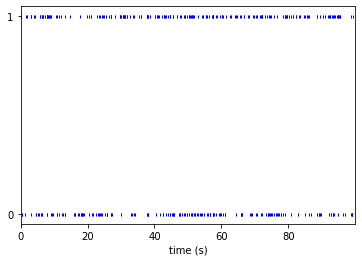

In [299]:
sw.plot_rasters(sorted_dic[u], color='b', unit_ids=[0, 1], trange=[0,100])

NEXT: PANDAS DF mit rows für die unit, columns: channel, number of spikes, firing rate, from channel -> layer, quality metrics, template features, 



In [83]:
st.validation.get_quality_metrics_list()

['num_spikes',
 'firing_rate',
 'presence_ratio',
 'isi_violation',
 'amplitude_cutoff',
 'snr',
 'max_drift',
 'cumulative_drift',
 'silhouette_score',
 'isolation_distance',
 'l_ratio',
 'd_prime',
 'noise_overlap',
 'nn_hit_rate',
 'nn_miss_rate']

In [201]:
features = st.postprocessing.compute_unit_template_features(
    loaded, sorted_dic['sec_0-300'], as_dataframe=False, upsampling_factor=10
    )

AttributeError: 'dict' object has no attribute 'get_channel_ids'

In [55]:
features

,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
0,0.000744,0.000124,-0.265574,0.075042,-0.000977
1,0.000820,0.000328,-0.474439,0.027238,-0.002525
10,0.000916,0.000316,-0.314959,0.039820,-0.008185
100,0.000548,0.000248,-0.086883,0.046373,-0.001005
101,0.002952,0.000232,0.015183,NaN,NaN
...,...,...,...,...,...
95,0.000616,0.000284,-0.342646,0.052901,-0.008465
96,0.000376,0.000196,-0.217725,0.053803,-0.001766
97,0.000484,0.000172,-0.412964,0.056041,-0.006332
98,0.001016,0.000332,-0.178314,0.190320,-0.016595


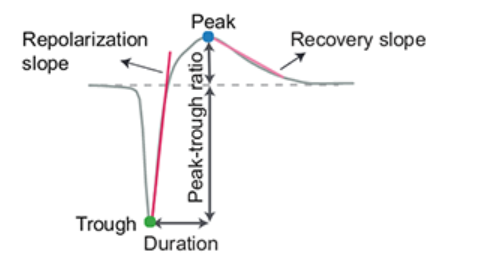

In [53]:

duration = recording_cache.get_num_frames()
isi_violations = st.validation.compute_isi_violations(sorting_SC, duration_in_frames=duration)
print('ISI violations:', isi_violations)



ISI violations: [1.27377826e+00 0.00000000e+00 0.00000000e+00 3.97387959e+00
 4.78976141e+00 0.00000000e+00 3.59827283e+00 1.79616053e+00
 3.51914414e-01 0.00000000e+00 1.58361486e+00 0.00000000e+00
 2.42349941e-01 4.32457803e-01 0.00000000e+00 3.19881806e-01
 1.57278965e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.19348108e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.91155850e+00 3.60251586e+00 9.52475696e+00
 3.67714653e+00 0.00000000e+00 0.00000000e+00 1.21621622e+01
 0.00000000e+00 0.00000000e+00 1.82654540e-01 0.00000000e+00
 0.00000000e+00 2.41169188e-01 6.08846639e-01 3.81035977e-01
 0.00000000e+00 0.00000000e+00 5.34887816e+00 1.20512903e+01
 1.76544668e+01 0.00000000e+00 4.86036797e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.95903716e+01 0.00000000e+00
 7.46754233e-01 8.35294212e+00 3.82133477e+00 0.00000000e+00
 1.39850567e+00 0.00000000e+00 6.02564515e+00 1.32883014e+00
 0.00000

In [58]:
snrs = st.validation.compute_snrs(sorting_SC, recording_cache)
print('SNRs:', snrs)

SNRs: [ 3.68636627  4.99554308  3.18057177  4.21515235  6.48695524 16.47788306
  6.74698088  3.09740276  3.54200631 19.45265132  6.05161192  6.83005729
  3.14511229  3.73828337  2.63011315  3.10949338  3.39905298 10.83804256
  9.25282723 10.05141044 10.31362115  4.25121935  4.28870312  2.84686789
  4.35701429 12.63011502 28.11184901 18.85550848 19.49441414 18.82434235
  3.83343396  9.16284214  6.9188808   3.41460294  5.7906752   2.68313285
 49.35861244 51.28883751  5.57954422  7.9454734   5.8452368   5.54158814
  5.37711178  3.21348321  3.35282604 19.21169203  4.33715866 16.37826537
  6.91144262 10.2215205   5.74629521  6.67544271 10.97788751 23.47493722
 19.81564139 19.25011385  5.76616313  7.51953204  3.50755759 12.44160584
  3.03998822 25.88247795  2.56383036  3.52831893 10.8603286   3.89303387
  4.13596312  3.34654212  7.89550864 10.04673394  3.63228073 11.1286899
  9.67577761  2.50395523  8.84112586  3.29883371  3.45798832  5.09267642
  3.18673465 11.68213013  7.05618529  3.511738

In [59]:
len(snrs)

502

In [61]:

quality_metrics = st.validation.compute_quality_metrics(sorting_SC, recording_cache, 
                                                        metric_names=['firing_rate', 'isi_violation', 'snr'], 
                                                        as_dataframe=True)
display(quality_metrics)

,firing_rate,isi_violation,snr
0,2.575000,1.273778,3.686366
1,0.258333,0.000000,4.995543
10,3.833333,0.000000,3.180572
100,6.991667,3.973880,4.215152
101,0.766667,4.789761,6.486955
...,...,...,...
95,3.008333,0.311082,3.359212
96,2.425000,1.436233,3.734944
97,3.483333,1.160131,2.839442
98,0.200000,0.000000,23.745528


In [66]:
quality_metrics['isi_violation'].min()

0.0

In [54]:
st.postprocessing.export_to_phy(recording_cache, 
                                sorting_SC, output_folder='phy_IC', verbose=True, recompute_info=True)

You can run spiketoolkit.preprocessing.bandpass_filter(recording, cache_to_file=True)
Converting to Phy format
Recomputing info
Number of chunks: 13 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##################################################| 13/13 [00:33<00:00,  2.56s/it]


Fitting PCA of 3 dimensions on 10000 waveforms
Projecting waveforms on PC
Saving files
Saved phy format to:  D:\Files_Reutlingen_Jenny\191021_extra\phy_IC
Run:

phy template-gui  D:\Files_Reutlingen_Jenny\191021_extra\phy_IC\params.py


# AUTOMATED CURATION


In [55]:
snr_thresh = 5
isi_viol_thresh = 0.5

In [56]:

sorting_auto = st.curation.threshold_isi_violations(sorting_SC, isi_viol_thresh, 'greater', duration)

In [59]:
len(sorting_auto.get_unit_ids())

277

In [61]:
len(sorting_SC.get_unit_ids())

502